In [83]:
%matplotlib inline

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import create_engine

# DB 접속 정보 로딩
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

In [85]:
# 1. 데이터 불러오기
# -----------------------------

# vehicle 데이터
vehicle = pd.read_sql("SELECT * FROM vehicle_reg_stats", con=engine)
vehicle['datetime'] = pd.to_datetime(vehicle['datetime'])

# pollution 데이터
pollution = pd.read_sql("SELECT * FROM air_pollution", con=engine)
pollution = pollution.drop(columns=['id'], errors='ignore')
pollution['datetime'] = pd.to_datetime(pollution['datetime'])

# quality 데이터
quality = pd.read_sql("SELECT * FROM air_quality", con=engine)
quality = quality.drop(columns=['id'], errors='ignore')
quality['datetime'] = pd.to_datetime(quality['datetime'])

In [86]:
# 2. 월별 데이터 집계
# -----------------------------

# 월별 연료유형별 등록대수 (unstack해서 연료유형이 열이 되도록)
monthly_fuel = vehicle.groupby([pd.Grouper(key='datetime', freq='M'), 'fuel_type'])['reg_count'].sum().unstack()

# 연료유형 컬럼명을 한글로 바꾸기 (원본에 따라 맞게 수정)
monthly_fuel = monthly_fuel.rename(columns={
    'diesel': '경유',
    'electric': '전기',
    'gasoline': '휘발유'
})

# pollution: 월별 평균
pollution_numeric_cols = pollution.select_dtypes(include='number').columns
monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M'))[pollution_numeric_cols].mean()

# quality: 월별 평균
quality_numeric_cols = quality.select_dtypes(include='number').columns
monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M'))[quality_numeric_cols].mean()


C:\Users\USER\AppData\Local\Temp\ipykernel_2452\695587976.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fuel = vehicle.groupby([pd.Grouper(key='datetime', freq='M'), 'fuel_type'])['reg_count'].sum().unstack()
C:\Users\USER\AppData\Local\Temp\ipykernel_2452\695587976.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M'))[pollution_numeric_cols].mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_2452\695587976.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M'))[quality_numeric_cols].mean()


In [87]:
# 3. 데이터 병합
# -----------------------------

# 1차 병합: 연료 + pollution
merged1 = pd.merge(monthly_fuel, monthly_pollution, left_index=True, right_index=True, how='inner')

# 2차 병합: + quality
merged = pd.merge(merged1, monthly_quality, left_index=True, right_index=True, how='inner')


In [88]:
# 4. 상관계수 계산
# -----------------------------

# 원하는 열 순서 지정
columns_order = ['경유', '전기', '휘발유', 'no2', 'co', 'so2', 'o3', 'pm10', 'pm25']
correlation_matrix = merged[columns_order].corr()

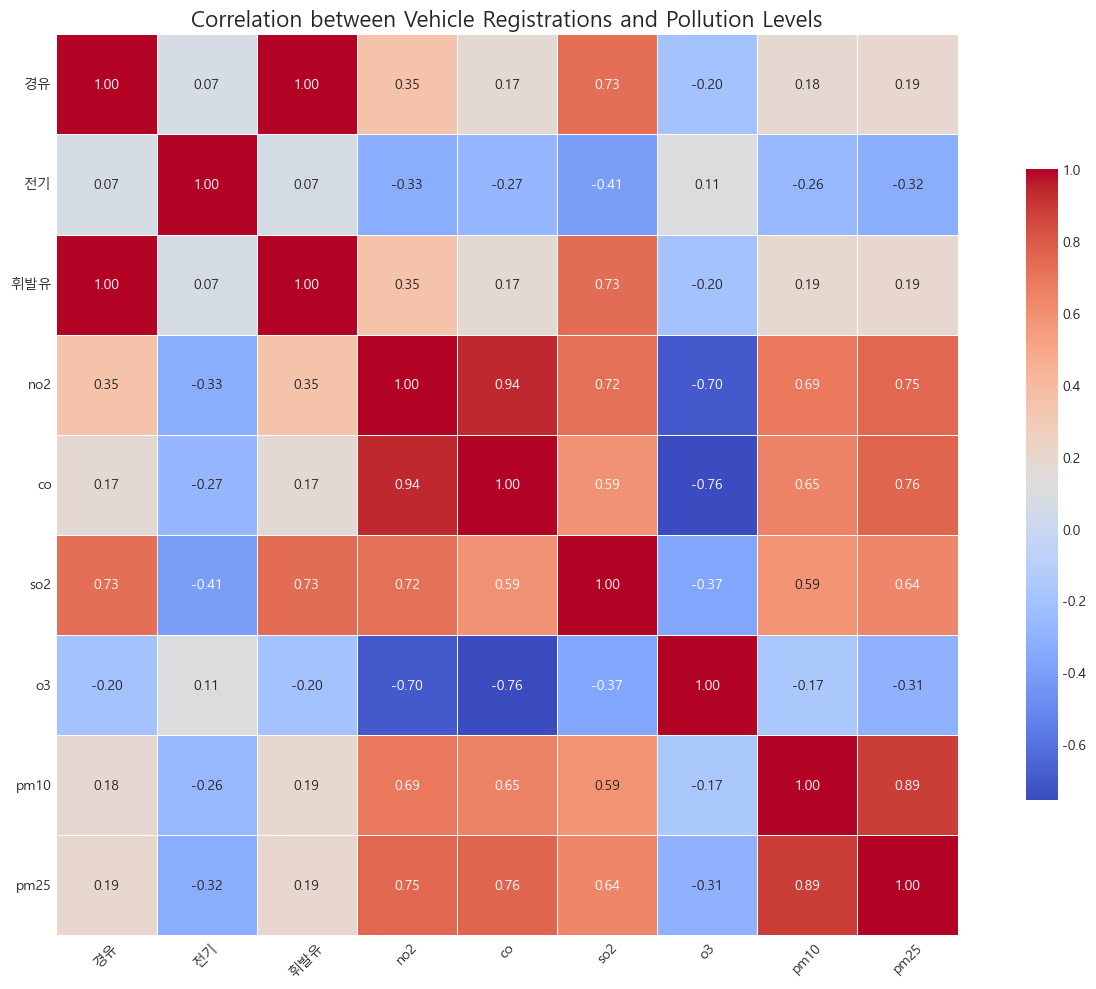

In [89]:

# 5. 히트맵 시각화
# -----------------------------

plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    square=True, 
    linewidths=0.5, 
    cbar_kws={'shrink': 0.7}
)
plt.title('Correlation between Vehicle Registrations and Pollution Levels', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_2452\1488391072.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(start=series.index[0], periods=len(X_future), freq='M')
C:\Users\USER\AppData\Local\Temp\ipykernel_2452\1488391072.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(start=series.index[0], periods=len(X_future), freq='M')
C:\Users\USER\AppData\Local\Temp\ipykernel_2452\1488391072.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(start=series.index[0], periods=len(X_future), freq='M')
C:\Users\USER\AppData\Local\Temp\ipykernel_2452\1488391072.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(start=series.index[0], periods=len(X_future), fr

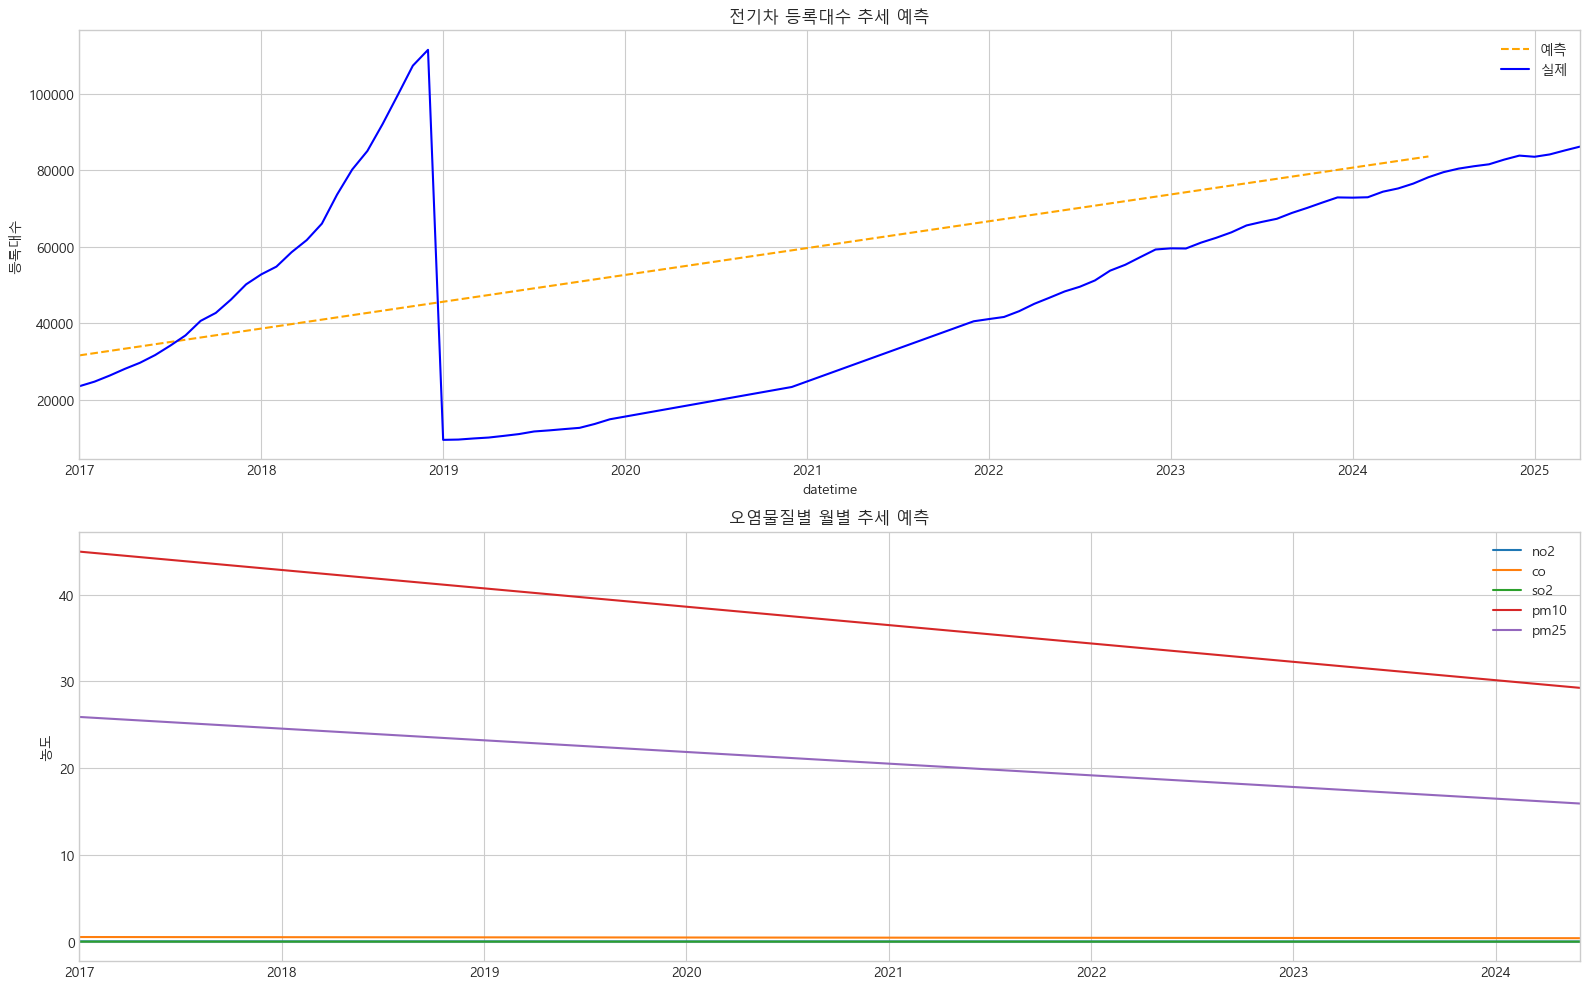

In [90]:
from sklearn.linear_model import LinearRegression
import numpy as np

def predict_trend(series, months_to_predict=12):
    """
    월별 시계열 데이터(Series) → 향후 `months_to_predict`개월 예측값 반환
    """
    series = series.dropna()
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values

    model = LinearRegression()
    model.fit(X, y)

    X_future = np.arange(len(series) + months_to_predict).reshape(-1, 1)
    y_future = model.predict(X_future)

    index_future = pd.date_range(start=series.index[0], periods=len(X_future), freq='M')
    return pd.Series(y_future, index=index_future)

# ▶ 1. 전기차 등록대수 예측
ev_series = monthly_fuel['전기']
ev_pred = predict_trend(ev_series)

# ▶ 2. 오염물질 예측
pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']
pollution_preds = {col: predict_trend(merged[col]) for col in pollutants}

# ▶ 3. 시각화
plt.figure(figsize=(16, 10))

# 전기차
plt.subplot(2, 1, 1)
ev_pred.plot(label='예측', style='--', color='orange')
ev_series.plot(label='실제', color='blue')
plt.title('전기차 등록대수 추세 예측')
plt.ylabel('등록대수')
plt.legend()

# 오염물질
plt.subplot(2, 1, 2)
for col in pollutants:
    pollution_preds[col].plot(label=col)
plt.title('오염물질별 월별 추세 예측')
plt.ylabel('농도')
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# ev_pred: 전기차 예측값
# merged: 과거 데이터 (ev + 오염물질)

from sklearn.linear_model import LinearRegression

# 오염물질별 회귀모델 생성
pollution_models = {}
for col in ['no2', 'co', 'so2', 'pm10', 'pm25']:
    df = merged[['전기', col]].dropna()
    model = LinearRegression().fit(df[['전기']], df[col])
    pollution_models[col] = model

# 전기차 예측값으로 미래 오염물질 예측
pollution_future = {}
for col, model in pollution_models.items():
    pollution_future[col] = model.predict(ev_pred.values.reshape(-1, 1))

c:\ex\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ex\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ex\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ex\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ex\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [92]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 625.1/625.1 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------- -------------------- 1.3/2.7 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


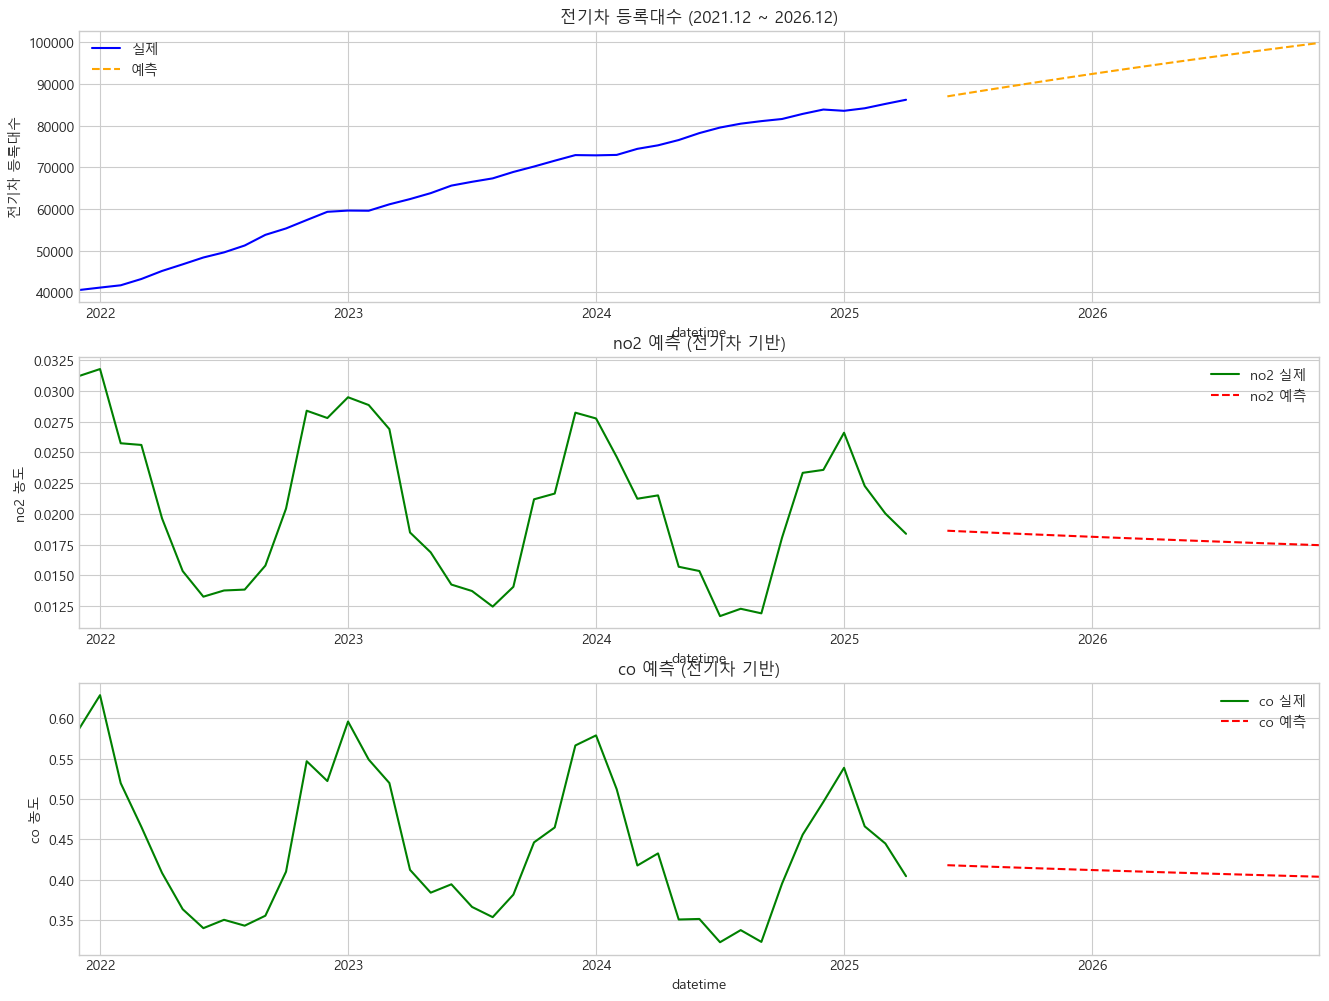

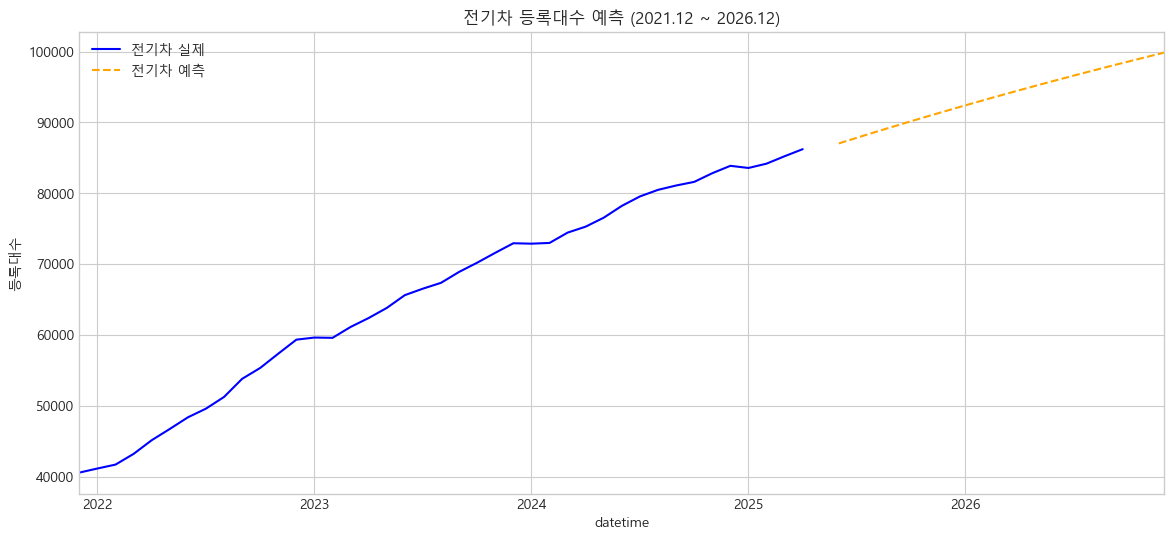

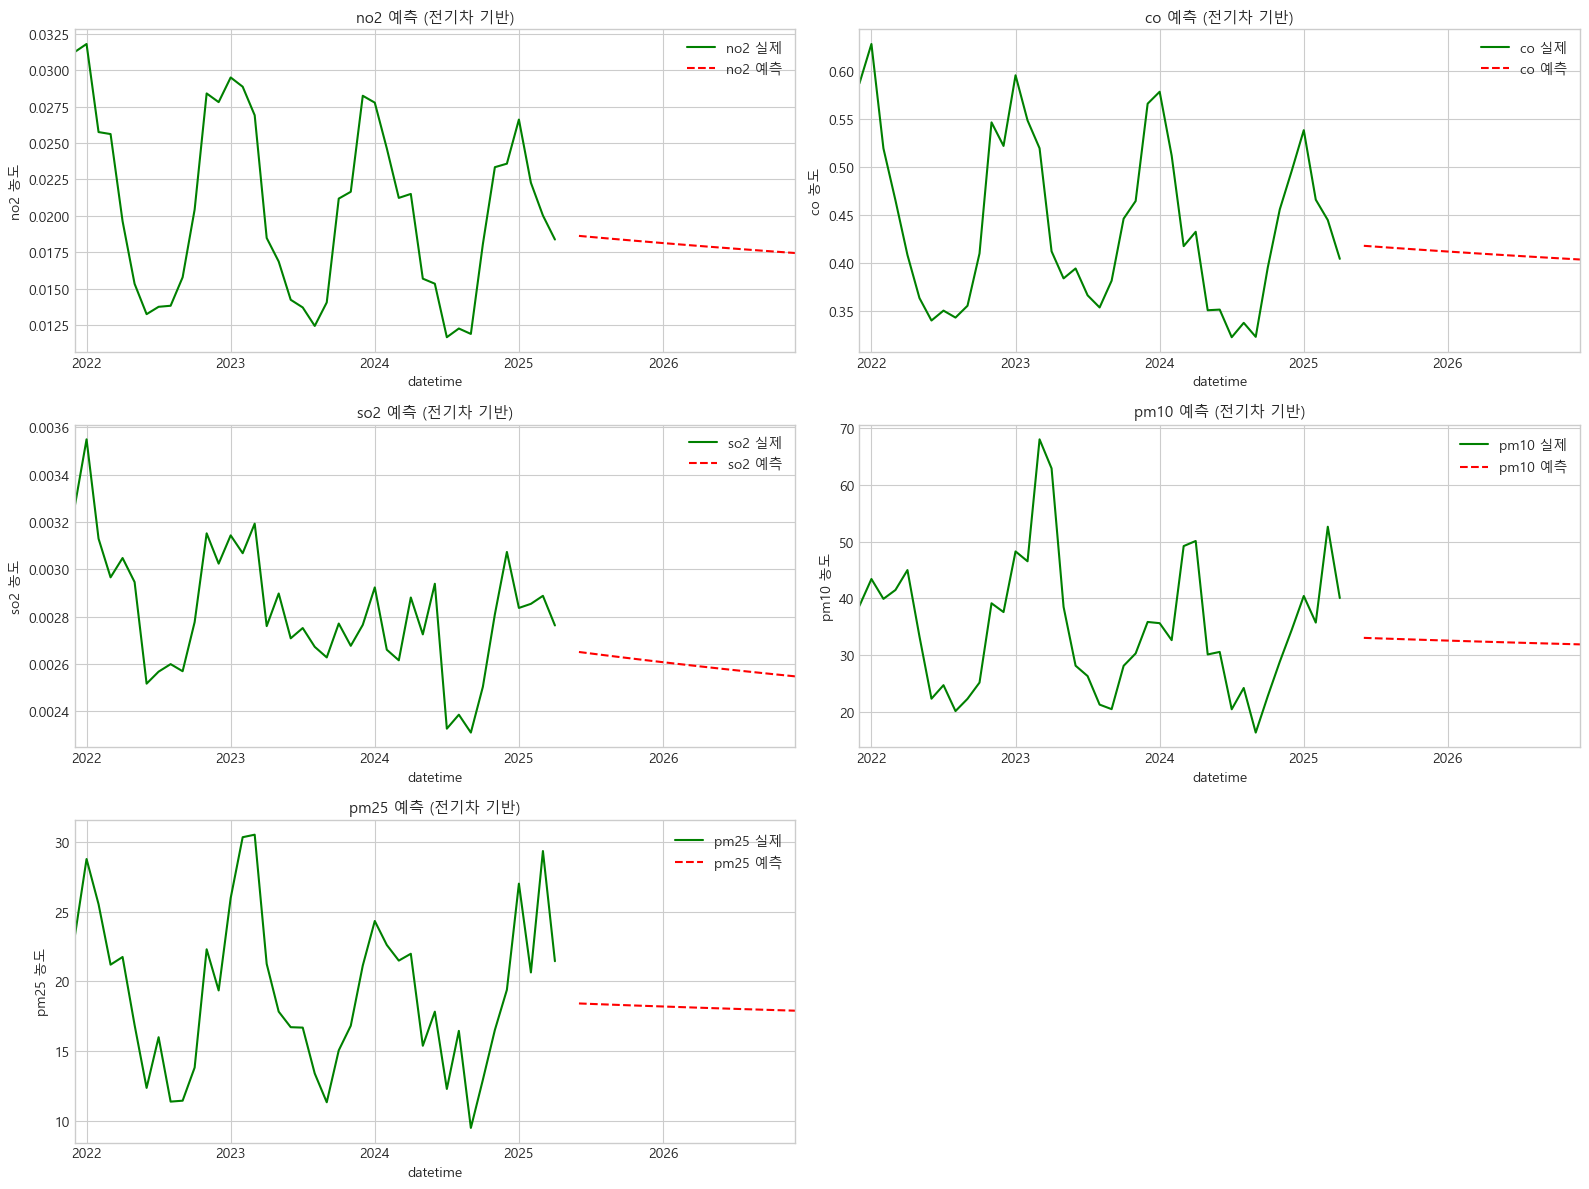

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. 데이터 자르기
# -------------------------
start_date = '2021-12-01'
end_date = '2025-05-01'

ev_series = monthly_fuel['전기']
ev_series = ev_series[(ev_series.index >= start_date) & (ev_series.index <= end_date)]

pollutants = ['no2', 'co', 'so2', 'pm10', 'pm25']
pollution_actual = merged[pollutants]
pollution_actual = pollution_actual[(pollution_actual.index >= start_date) & (pollution_actual.index <= end_date)]

# -------------------------
# 2. 전기차 ARIMA 예측 (19개월)
# -------------------------
model = ARIMA(ev_series, order=(1, 1, 1))
model_fit = model.fit()
forecast_ev = model_fit.forecast(steps=19)

# 날짜 인덱스 생성 (freq='MS': 월 시작 기준으로 변경)
future_index = pd.date_range(start='2025-06-01', periods=19, freq='MS')
ev_forecast = pd.Series(forecast_ev.values, index=future_index)

# -------------------------
# 3. 오염물질 예측 (선형 회귀)
# -------------------------
pollution_pred = {}
for col in pollutants:
    df = pd.DataFrame({
        'ev': ev_series,
        'pollution': pollution_actual[col]
    }).dropna()

    lin_model = LinearRegression()
    lin_model.fit(df[['ev']], df['pollution'])

    pollution_pred[col] = lin_model.predict(ev_forecast.values.reshape(-1, 1))

# -------------------------
# 4. 시각화
# -------------------------

# (1) 전기차 예측
plt.figure(figsize=(14, 6))
ev_series.plot(label='전기차 실제', color='blue')
ev_forecast.plot(label='전기차 예측', style='--', color='orange')
plt.title('전기차 등록대수 예측 (2021.12 ~ 2026.12)')
plt.ylabel('등록대수')
plt.legend()
plt.show()

# (2) 오염물질 예측 (5개 변수 시각화)
plt.figure(figsize=(16, 12))

for i, col in enumerate(pollutants, start=1):
    plt.subplot(3, 2, i)
    pollution_actual[col].plot(label=f'{col} 실제', color='green')
    pd.Series(pollution_pred[col], index=future_index).plot(label=f'{col} 예측', style='--', color='red')
    plt.title(f'{col} 예측 (전기차 기반)', fontsize=11)
    plt.ylabel(f'{col} 농도')
    plt.legend()

plt.tight_layout()
plt.show()